## Purpose of this notebook

Analyzing the knowledge graph data, to extract insights about the relevant pathways and GO terms associated with sepsis by looking into the upregulated and downregulated genes.

## Library Loading

In [1]:
# To install the owlready2 library: pip install owlready2

from owlready2 import *

## KG files loading

In [ ]:
dataset_v210 = get_ontology("../../../output/GSE54514_enriched_ontology_degfilter_v2.10_ovp0.2_ng4.owl").load()
dataset_v211 = get_ontology("../../../output/GSE54514_enriched_ontology_degfilter_v2.11_ovp0.2_ng4.owl").load()

## Exploration

In [3]:
# First Dataset
onto = dataset_v210

In [4]:
# Retrieving all individual instances belonging to the Protein class
proteins = list(onto.Protein.instances())
print(f"Number of Protein instances in dataset v2.10: {len(proteins)}")

Number of Protein instances in dataset v2.10: 1288


In [5]:
# Selecting a protein instance to explore

protein_instance = proteins[0]
protein_instance.name

'Protein_AASDHPPT'

In [6]:
# Exploring properties of the selected protein instance

for prop in onto.properties():
    values = prop[protein_instance]
    if values:
        print(f"{prop.name}: {values}")

hasPhysicalInteractionWith: [GSE54514_enriched_ontology_degfilter_v2.10_ovp0.2_ng4.Protein_HNRNPH1, GSE54514_enriched_ontology_degfilter_v2.10_ovp0.2_ng4.Protein_STIL, GSE54514_enriched_ontology_degfilter_v2.10_ovp0.2_ng4.Protein_EFHC2, GSE54514_enriched_ontology_degfilter_v2.10_ovp0.2_ng4.Protein_HNRNPH1, GSE54514_enriched_ontology_degfilter_v2.10_ovp0.2_ng4.Protein_STIL, GSE54514_enriched_ontology_degfilter_v2.10_ovp0.2_ng4.Protein_EFHC2]
hasFunctionalInteractionWith: [GSE54514_enriched_ontology_degfilter_v2.10_ovp0.2_ng4.Protein_TMEM126A, GSE54514_enriched_ontology_degfilter_v2.10_ovp0.2_ng4.Protein_DLD, GSE54514_enriched_ontology_degfilter_v2.10_ovp0.2_ng4.Protein_TMEM126A, GSE54514_enriched_ontology_degfilter_v2.10_ovp0.2_ng4.Protein_DLD]
isAssociatedWithGO: [obo.GO_0005737_instance, obo.GO_0005515_instance, obo.GO_0005829_instance, obo.GO_0005622_instance, obo.GO_0043227_instance, obo.GO_0043226_instance, obo.GO_0005488_instance, obo.GO_0019538_instance, obo.GO_0009056_instance, 

## Information Extraction

In [7]:
from kg_analysis import extract_protein_data

# Processing the first dataset (v2.10)
df_v210 = extract_protein_data(dataset_v210)

# Processing the second dataset (v2.11)
df_v211 = extract_protein_data(dataset_v211)

## Results Analysis

In [8]:
# Counting the regulation types for both versions
dist_v210 = df_v210['regulation'].value_counts()
dist_v211 = df_v211['regulation'].value_counts()

print("--- Regulation Distribution Comparison ---")
print(f"Version 2.10:\n{dist_v210}\n")
print(f"Version 2.11:\n{dist_v211}")

--- Regulation Distribution Comparison ---
Version 2.10:
regulation
No change        1278
Upregulated         7
Downregulated       3
Name: count, dtype: int64

Version 2.11:
regulation
No change        1278
Upregulated         7
Downregulated       3
Name: count, dtype: int64


In [9]:
# Checking if the number of proteins and their mean Log2FC are the same

print(f"V2.10 Proteins: {len(df_v210)} | Mean Log2FC: {df_v210['log2_fc'].mean():.4f}")
print(f"V2.11 Proteins: {len(df_v211)} | Mean Log2FC: {df_v211['log2_fc'].mean():.4f}")

V2.10 Proteins: 1288 | Mean Log2FC: -0.0391
V2.11 Proteins: 1288 | Mean Log2FC: -0.0391


In [10]:
# Checking if the proteins have same regulation status in both datasets 

# Setting the protein ID as the index for both tables to allow direct alignment
df_v210_indexed = df_v210.set_index('protein').sort_index()
df_v211_indexed = df_v211.set_index('protein').sort_index()

# Comparing the 'regulation' column between the two versions
regulation_diff = df_v210_indexed['regulation'].compare(df_v211_indexed['regulation'])

if regulation_diff.empty:
    print("All proteins have the exact same regulation status in both v2.10 and v2.11.")
else:
    print("Differences found in regulation status:")
    print(regulation_diff)

All proteins have the exact same regulation status in both v2.10 and v2.11.


In [11]:
# Verifying the number of significant genes (P < 0.05)

# Calculating significant proteins for v2.10
significant_v210 = df_v210[df_v210['p_value'] < 0.05]
count_v210 = len(significant_v210)

# Calculating significant proteins for v2.11
significant_v211 = df_v211[df_v211['p_value'] < 0.05]
count_v211 = len(significant_v211)

print(f"--- Statistical Significance Check (P < 0.05) ---")
print(f"Version 2.10: {count_v210} significant proteins out of {len(df_v210)}")
print(f"Version 2.11: {count_v211} significant proteins out of {len(df_v211)}")

--- Statistical Significance Check (P < 0.05) ---
Version 2.10: 1288 significant proteins out of 1288
Version 2.11: 1288 significant proteins out of 1288


In [12]:
# Function to calculate magnitude stats of log2FC for each regulation category

def get_magnitude_stats(df, version_label):
    print(f"--- Log2FC Magnitude Stats: {version_label} ---")
    
    # Grouping by regulation and looking at the absolute Log2FC
    stats = df.groupby('regulation')['log2_fc'].apply(lambda x: x.abs().agg(['min', 'median', 'mean', 'max']))
    
    # Unstacking for a cleaner table view
    print(stats.unstack().round(4))
    print("\n")

# Running the analysis for both versions
get_magnitude_stats(df_v210, "v2.10")
get_magnitude_stats(df_v211, "v2.11")

--- Log2FC Magnitude Stats: v2.10 ---
                  min  median    mean     max
regulation                                   
Downregulated  0.7563  0.7581  0.7629  0.7742
No change      0.0365  0.2067  0.2307  0.7431
Upregulated    0.7961  0.8929  0.8873  0.9942


--- Log2FC Magnitude Stats: v2.11 ---
                  min  median    mean     max
regulation                                   
Downregulated  0.7563  0.7581  0.7629  0.7742
No change      0.0365  0.2067  0.2307  0.7431
Upregulated    0.7961  0.8929  0.8873  0.9942




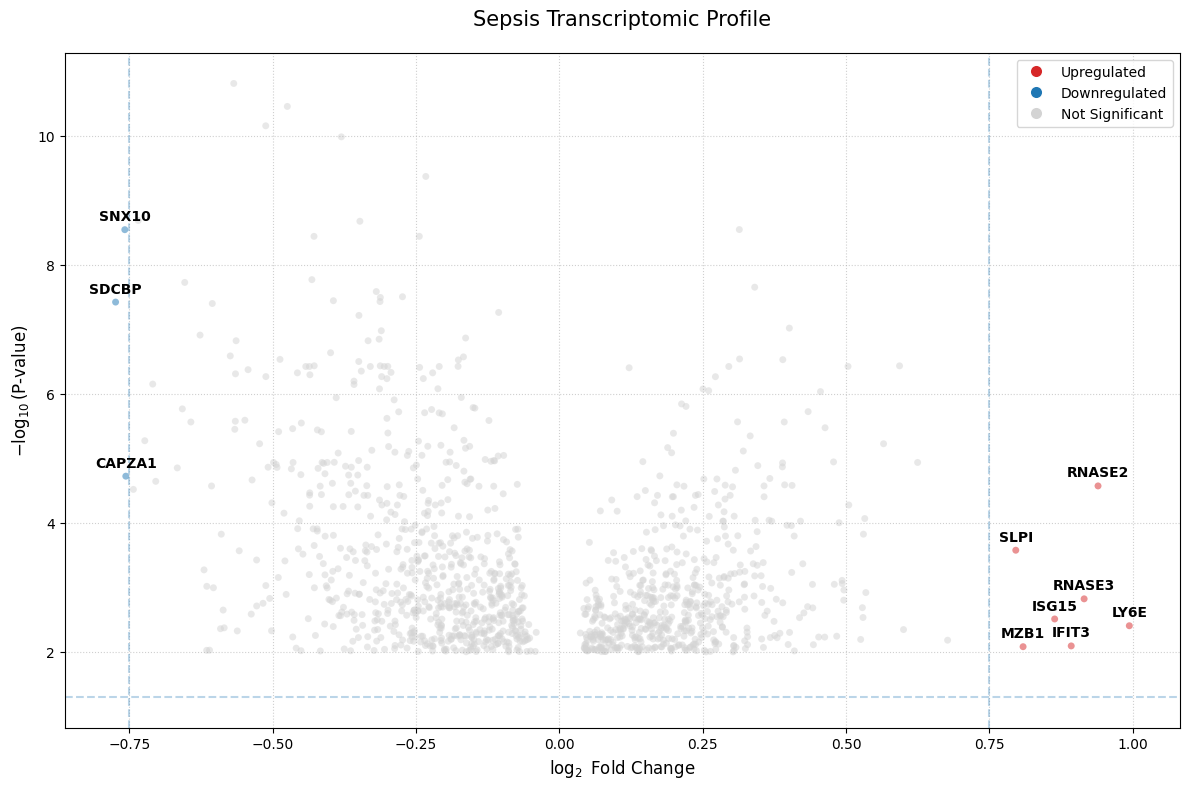

In [13]:
# -----------------------------------------------------------------------------
# Volcano Plot Visualization
# -----------------------------------------------------------------------------

from volcano_plotting import plot_volcano

fc_threshold = 0.75
p_threshold = 0.05

output_path = "../../../results/EDA/KG_Analysis/volcano_plot_v211.png"
plot_title = "Sepsis Transcriptomic Profile"

plot_volcano(
    df=df_v211,
    fc_thresh=0.75,
    p_thresh=0.05,
    n_labels=10,
    title=plot_title,
    output_file=output_path
)

In [14]:
# -----------------------------------------------------------------------------
# Execute descriptive analysis
# -----------------------------------------------------------------------------

from kg_analysis import descriptive_biological_report

results_mapping = descriptive_biological_report(df_v211)


SEPSIS BIOLOGICAL INSIGHTS
Descriptive analysis of differentially regulated proteins

UPREGULATED (7 proteins)
Top impact proteins: LY6E, RNASE2, RNASE3, IFIT3, ISG15, MZB1, SLPI

Note: Term frequencies indicate annotation prevalence in the knowledge graph and do not represent statistical enrichment.



Top 10 Pathway associations
Name / Description                                                   ID                       Frequency
-------------------------------------------------------------------  ---------------------  -----------
Pathway_0000000                                                      Pathway_0000000                  6
Immune System                                                        Pathway_R-HSA-168256             5
Innate Immune System                                                 Pathway_R-HSA-168249             4
Neutrophil degranulation                                             Pathway_R-HSA-6798695            3
Interferon alpha/beta signaling                                      Pathway_R-HSA-909733             2
Interferon Signaling                                                 Pathway_R-HSA-913531             2
Cytokine Signaling in Immune system                                  Pathway_R-HSA-1280215            2
Metabolism of proteins              

Top 10 GO associations
Name / Description                  ID            Frequency
----------------------------------  ----------  -----------
immune system process               GO_0002376            7
response to stimulus                GO_0050896            7
binding                             GO_0005488            7
cellular anatomical structure       GO_0110165            7
response to biotic stimulus         GO_0009607            6
response to stress                  GO_0006950            6
defense response to other organism  GO_0098542            6
protein binding                     GO_0005515            6
defense response                    GO_0006952            6
defense response to symbiont        GO_0140546            6

DOWNREGULATED (3 proteins)
Top impact proteins: SDCBP, SNX10, CAPZA1

Note: Term frequencies indicate annotation prevalence in the knowledge graph and do not represent statistical enrichment.



Top 10 Pathway associations
Name / Description                    ID                       Frequency
------------------------------------  ---------------------  -----------
Pathway_0000000                       Pathway_0000000                  2
Immune System                         Pathway_R-HSA-168256             2
Innate Immune System                  Pathway_R-HSA-168249             2
Developmental Biology                 Pathway_R-HSA-1266738            1
Axon guidance                         Pathway_R-HSA-422475             1
Ephrin signaling                      Pathway_R-HSA-3928664            1
EPH-Ephrin signaling                  Pathway_R-HSA-2682334            1
Regulation of necroptotic cell death  Pathway_R-HSA-5675482            1
Neurofascin interactions              Pathway_R-HSA-447043             1
Neutrophil degranulation              Pathway_R-HSA-6798695            1



Top 10 GO associations
Name / Description                             ID            Frequency
---------------------------------------------  ----------  -----------
organelle organization                         GO_0006996            3
cellular component organization                GO_0016043            3
intracellular membraneless organelle           GO_0043232            3
cytoplasm                                      GO_0005737            3
intracellular anatomical structure             GO_0005622            3
membraneless organelle                         GO_0043228            3
cellular component organization or biogenesis  GO_0071840            3
membrane-bounded organelle                     GO_0043227            3
cytoskeleton                                   GO_0005856            3
vesicle                                        GO_0031982            3



In [15]:
# -----------------------------------------------------------------------------
# Execute enrichment analysis
# -----------------------------------------------------------------------------

from kg_analysis import perform_enrichment

go_up = perform_enrichment('GO', "Upregulated", df_v211, results_mapping)
go_down = perform_enrichment('GO', "Downregulated", df_v211, results_mapping)
pathway_up = perform_enrichment('Pathway', "Upregulated", df_v211, results_mapping)
pathway_down = perform_enrichment('Pathway', "Downregulated", df_v211, results_mapping)

print("GO Enrichment Upregulated Terms:")
print(go_up.head())
print("GO Enrichment Downregulated Terms:")
print(go_down.head())
print("Pathway Enrichment Upregulated Terms:")
print(pathway_up.head())
print("Pathway Enrichment Downregulated Terms:")
print(pathway_down.head())

GO Enrichment Upregulated Terms:
                  Term  Count_in_set  Count_in_background  Gene_Ratio  \
0  GO_0009607_instance             6                  147    0.857143   
1  GO_0006950_instance             6                  357    0.857143   
2  GO_0002376_instance             7                  227    1.000000   
3  GO_0050896_instance             7                  624    1.000000   
4  GO_0098542_instance             6                  114    0.857143   

    p_value       FDR     Category  -log10_FDR  
0  0.000013  0.000276  Upregulated    3.559431  
1  0.002356  0.027366  Upregulated    1.562787  
2  0.000005  0.000185  Upregulated    3.733786  
3  0.006156  0.065451  Upregulated    1.184085  
4  0.000003  0.000139  Upregulated    3.856683  
GO Enrichment Downregulated Terms:
                  Term  Count_in_set  Count_in_background  Gene_Ratio  \
0  GO_0033043_instance             2                  133    0.666667   
1  GO_0005634_instance             2                 

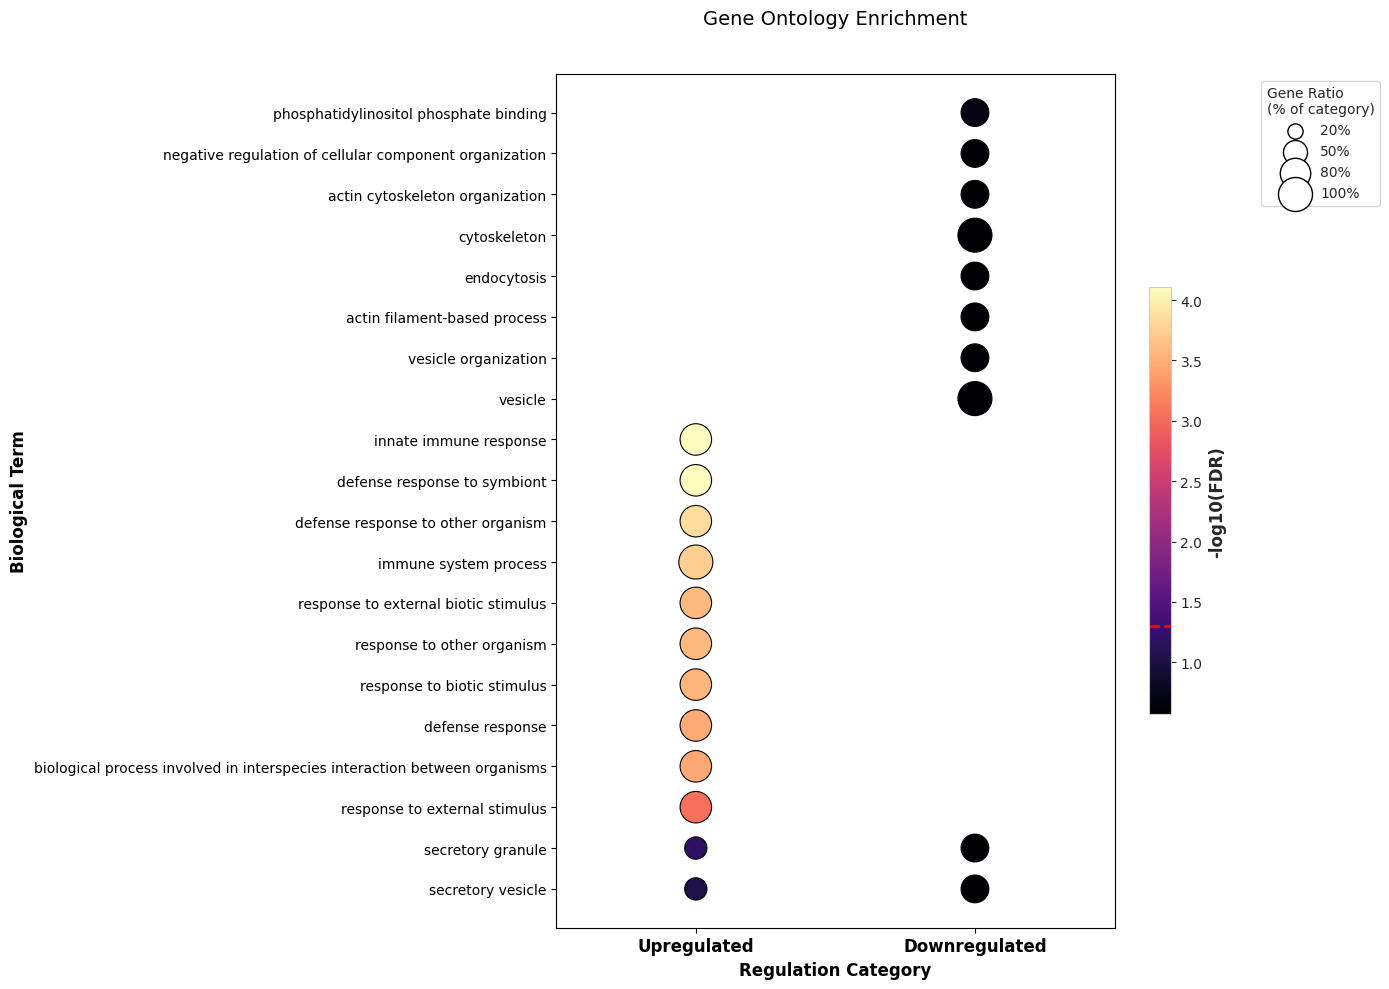

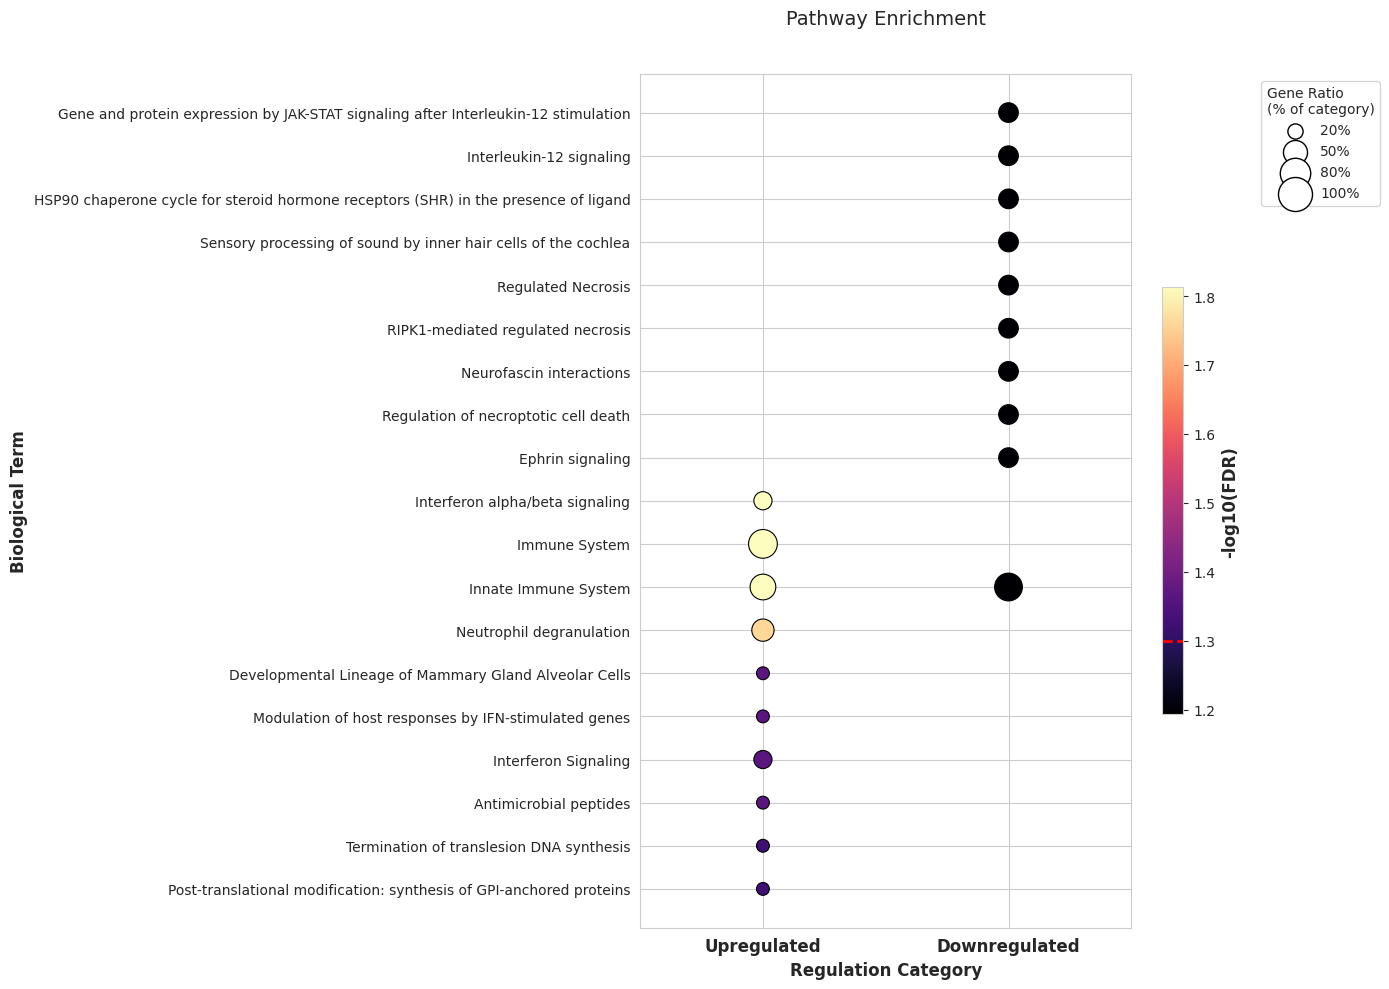

In [16]:
# -----------------------------------------------------------------------------
# Enrichment Plotting
# -----------------------------------------------------------------------------

from kg_analysis import get_biological_name
import pandas as pd

# Preparing for plotting
enrichment_df = pd.concat([go_up, go_down, pathway_up, pathway_down], ignore_index=True)
enrichment_df['Term_name'] = enrichment_df['Term'].apply(get_biological_name)
enrichment_df['Term_type'] = enrichment_df['Term'].apply(
    lambda x: 'GO' if x.startswith('GO_') else ('Pathway' if x.startswith('Pathway_') else 'Other')
)

from enrichment_plotting import plot_enrichment_results

# Go Enrichment Plot
plot_enrichment_results(
    enrichment_df, 
    term_type="GO", 
    top_n=10,
    fdr_threshold=0.5,
    title_prefix="Gene Ontology Enrichment",
    output_file="../../../results/EDA/KG_Analysis/go_enrichment_plot.png"
)

# Pathway Enrichment Plot
plot_enrichment_results(
    enrichment_df, 
    term_type="Pathway", 
    top_n=10, 
    fdr_threshold=0.1,
    title_prefix="Pathway Enrichment",
    output_file="../../../results/EDA/KG_Analysis/pathway_enrichment_plot.png"
)